In [145]:
%matplotlib inline

import skimage.color
import skimage.io
import skimage.filters
import skimage.feature

import numpy
import matplotlib.pyplot as plt
import math

## Edge detect operators

In [197]:
def convolve_kernel(image, kernel):
    if kernel.shape != (3, 3):
        raise ValueError("Kernel must have shape 3x3")
    
    out = numpy.ndarray(shape=image.shape, dtype=image.dtype)
    height, width = image.shape
    
    for x in range(0, width):
        for y in range(0, height):
            new_value = 0.0
            for kx in range(0, kernel.shape[1]):
                for ky in range(0, kernel.shape[0]):
                    # if trying to access outside image, instead use closest value
                    sx = min(max(x+kx-1, 0), width-1)
                    sy = min(max(y+ky-1, 0), height-1)
                    #sx = x+kx-1
                    #sy = y+ky-1
                    k = kernel[ky][kx]
                    s = image[sy][sx]
                    new_value += (s * k)
                    #print((x, y), (sx, sy), k, new_value)
            out[y][x] = new_value
    return out
    
kernels = {
    'prewitt_x': numpy.array((
        (-1, 0, 1),
        (-1, 0, 1),
        (-1, 0, 1),
     )) / 3.0,
    'prewitt_y': numpy.array((
        (-1, -1, -1),
        (0, 0, 0),
        (1, 1, 1),
     )) / 3.0,
    'sobel_x': numpy.array((
        (-1, 0, 1),
        (-2, 0, 2),
        (-1, 0, 1),
     )) / 4.0,
    'sobel_y': numpy.array((
        (-1, -2, -1),
        (0, 0, 0),
        (1, 2, 1),
     )) / 4.0,
    'goodsobel_x': numpy.array((
        (-3, 0, 3),
        (-10, 0, 10),
        (-3, 0, 3),
     )) / 16.0,
    'goodsobel_y': numpy.array((
        (-3, -10, -3),
        (0, 0, 0),
        (3, 10, 3),
     )) / 16.0,
    'boxblur': numpy.array((
        (1, 1, 1),
        (1, 1, 1),
        (1, 1, 1),
     )) / 9.0,
    'laplacian4': numpy.array((
        (0, 1, 0),
        (1, -4, 1),
        (0, 1, 0),
     )) / 1.0,
    'laplacian12': numpy.array((
        (1, 2, 1),
        (2, -12, 2),
        (1, 2, 1),
     )) / 12.0,
}
                             
def edge_operator(image, operator):
    """Returns the reusult from one of the edge operators, prewitt, sobel,
    canny eller laplace
    Parameters:
    -----------
    image : np.ndarray
    Image to detect blobs in. If this image is a colour image then
    the last dimension will be the colour value (as RGB values).
    operator : numeric
    1. = sobel filter
    2. = prewitt filter
    3. = canny filter
    4. = laplace filter
    Returns:
    --------
    filtered : np.ndarray(np.uint)
    result image from the edge operator
    """
    
    if operator in ('sobel', 'prewitt', 'goodsobel'):
        # Get edges in X,T separately
        kernel_x = kernels['{}_x'.format(operator)]
        kernel_y = kernels['{}_y'.format(operator)]
        x = convolve_kernel(image, kernel_x)
        y = convolve_kernel(image, kernel_y)
        # Calculate edge magnitude
        return numpy.sqrt(x**2 + y**2)
    
    elif operator == 'laplacian':
        k = kernels['laplacian12']
        #l = numpy.abs(convolve_kernel(image, k))
        l = convolve_kernel(image, k)
        return l
    
    # Using skimage implementations as references
    elif operator == 'sobelref':
        return skimage.filters.sobel(image)
    elif operator == 'laplacianref':
        return skimage.filters.laplace(image, ksize=7)
    
    elif operator == 'canny':
        # FIXME: implement
        # Canny (p.133) is more complicated
        # Smooth image with Gaussian filter
        # Calculate x/y gradient vector, local gradient magnitude/orientation
        # Isolate local maxima of gradient magnitude using 'non-maximum supression' along local gradient direction
        # Collect sets of connected edge pixels from local maxima using hysteresis threshold
        return skimage.feature.canny(image, sigma=2.0)
    else:
        raise ValueError('Unknown operator {}'.format(operator))


## Comparison of edge detect operators

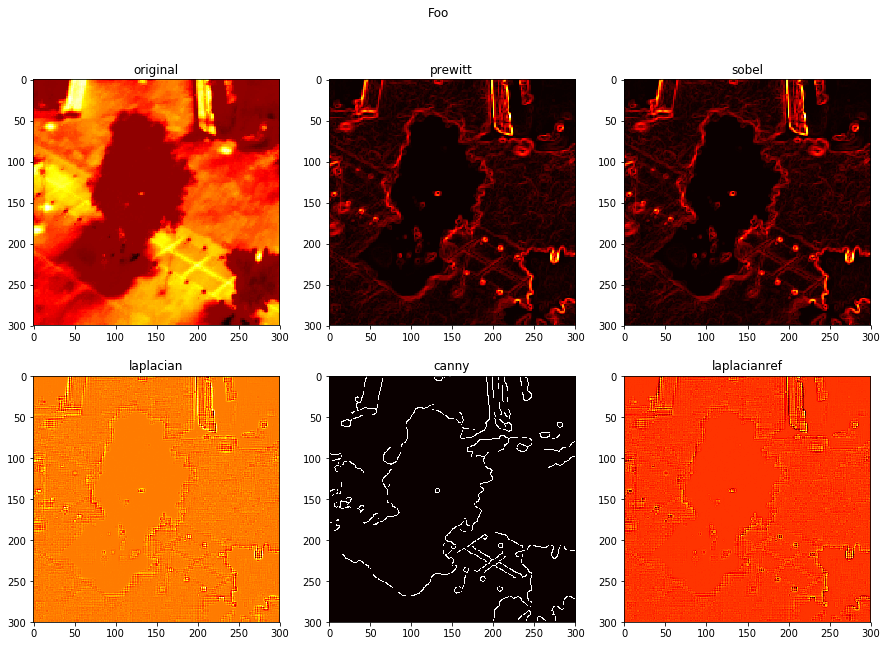

In [200]:
def plot_method_comparison(img):

    methods = ('original', 'prewitt', 'sobel', 'laplacian', 'canny', 'laplacianref')
    figure, plots = plt.subplots(2, math.ceil(len(methods)/2), figsize=(15, 10))
    plots = plots.flatten()
    
    figure.suptitle("Foo")
    
    for method, ax in zip(methods, plots):
        if method == 'original':
            out = img
        else:
            out = edge_operator(img, method)
            treshold = skimage.filters.threshold_otsu(out)
            #out = out <= treshold
        ax.set_title(method)
        ax.imshow(out, cmap='hot')

    return figure

raw = skimage.io.imread("AthenIR.png")
gray = skimage.color.rgb2gray(raw)
plot_method_comparison(gray[500:800, 500:800]);

## Image sharpening methods

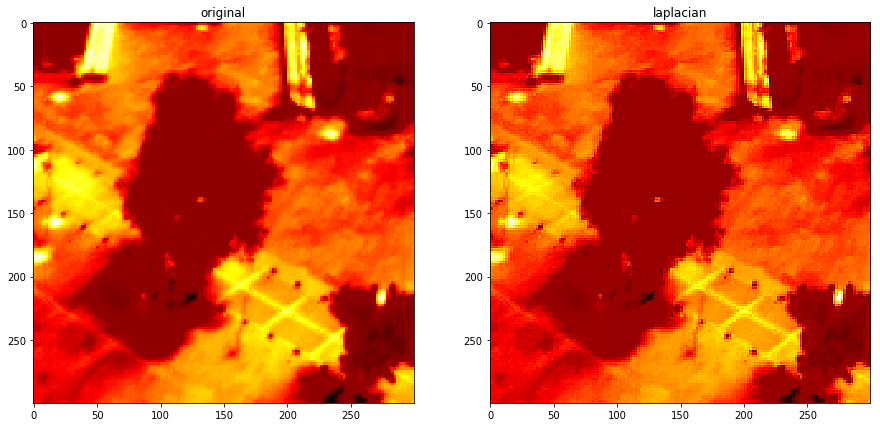

In [202]:
def sharpen(image, method, factor=0.1):
    """Performs an image sharpening using Laplace filter or unsharpen mask 
    (USM)
    1. = Laplace
    2. = USM
    Returns: sharpened image
    """
    
    if method == 'laplacian':
        # Laplace sharpening done by applying Laplacian filter,
        # then from image subtracting a fraction of it
        laplaced = convolve_kernel(image, kernels['laplacian12'])
        sharpened = image - (factor * laplaced)
        return sharpened
    elif method == 'usm':
        # Unsharpen-mask
        # Subtract from input a smoothened image, result is the mask
        # Add the mask to input, weigthed by factor A
        # Smoothening filter is typically a Gaussian filter
        raise NotImplementedError('usm not implemented')
    else:
        raise ValueError('Unknown sharpening method {}'.format(method))    

def plot_sharpen_methods(img):
        
    methods = ('original', 'laplacian')
    rows = 1
    figure, plots = plt.subplots(rows, math.ceil(len(methods)/rows), figsize=(15, 10))
    plots = plots.flatten()
    
    #figure.suptitle("Sharpening methods")
    
    for method, ax in zip(methods, plots):
        if method == 'original':
            out = img
        else:
            out = sharpen(img, method, 0.9)
        ax.set_title(method)
        ax.imshow(out, cmap='hot')

    return figure
        
raw = skimage.io.imread("AthenIR.png")
gray = skimage.color.rgb2gray(raw)
plot_sharpen_methods(gray[500:800, 500:800]);

describe the resulting images. Which algorithms and with which parameters do you think yielded the best image sharpening in this case 